## Análisis de Sentimientos de críticas de películas

Junto con Keras, viene un ejemplo imdb_lstm.py. Este ejercicio esta prácticamente basado en él.

Es un gran ejemplo del uso de las RNNs.  El conjunto de datos que se utilizará consta de críticas de películas generadas por usuarios, y una classificación indicando si le gustó, o no, basado en su rating asociado. 

Hay más información de este conjunto de datos en:

https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

Como la comprensión del lenguaje escrito requiere "llevar cuenta" de todas las palabras en una oración, necesitamos una RNN para mantener una "memoria" de las palabras que pasaron antes, conforme va "leyendo" oraciones a lo largo del tiempo. 

En particular, se usarán unidades LSTM (Long Short-Term Memory) porque no es deseable "olvidar" palabras demasiado rápido...las palabras al inicio de una oración pueden afectar el significado de la misma grandemente.

Empezamos por la importación de lo que se requiere:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

Ahora importar los datos para entrenamiento y prueba.  Para que sea más manejable, se especifica que se quieren solamente las 20,000 palabras más populares en el conjunto de datos. Por algún motivo, este conjunto tiene una relación de 50% entreno y 50% prueba. 

In [2]:
print('Cargando los datos...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

Cargando los datos...


In [3]:
len(X_train)

25000

In [4]:
len(X_test)

25000

A ver cómo son los datos, el primer elemento de entrenamiento debe ser una crítica de una película:

In [27]:
X_train.shape

(25000, 80)

Esto no parece una crítica de una película!!!!  Resulta que la gente que preparó los datos ya hizo algo de preparación previa de los datos.  Estos números coinciden con el índice correspondiente a cada palabra de la crítica.  En realidad las palabras en sí, no son de interés...el modelo requiere números no palabras. 

Lo triste es que no será posible leer las críticas...siquiera para tener una idea de si funciona el análiisis, o no.

Y, ¿cómo son las etiquetas (metas)?

In [6]:
y_train[0]

1

Son simplemente 0 ó 1, que indica sí al que escribió la crítica le gustó, o no, la película.

Para resumir, para el entrenamiento se tiene un conjunto de críticas de películas que han sido convertidas a vectores de palabras representadas por enteros, y una clasificación de sentimiento binaria.

Las RNNs pueden "explotar" muy rápidamente (se habló de esto en clase).  Para que no se sobrecarguen las PCs que se podrían usar, se limitarán las críticas a las primeras 80 palabras:

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen = 80)
X_test = sequence.pad_sequences(X_test, maxlen = 80)

## Configuración del modelo

Considerando lo complejo que es una RNN LSTM (debajo del "capó"), es increíble lo simple que resulta esta parte utilizando Keras.

Se empieza con una capa de incrustación "embedded".  La función de esta es convertir los datos de entrada a vectores densos de un tamaño fijo que son más adecuados para una red neuronal.  Esto es típico cuando se manejan indices de datos basados en texto.  El 20,000 representa el tamaño del vocabulario (límite impuesto para este ejercicio, pero puede variarse dependiendo de la capacidad de cómputo que se tiene) y 128 es la dimensión de 128 unidades de salida.

Luego se coloca una capa LSTM y ya!  Se especifica 128 para igualar la salida de la capa de incrustación, y se utiliza la opción de "botar" unidades para evitar el sobre ajuste, que es una característica muy común de las RNN.

Finalmente se debe reducir todo a una unidad de salida con una función de activación sigmoidal para seleccionar la clasificación binaria de sentimiento de 0 ó 1.

In [54]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import SpatialDropout1D

# Topologia original
modelo_original = Sequential([
    Embedding(50000, 128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Topologia agregada
modelo_nuevo = Sequential([
    # Embedding
    Embedding(50000, 128, mask_zero=True,
          embeddings_regularizer=regularizers.l2(1e-6),
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,
    ),
    LSTM(64,
        recurrent_dropout=0.2,
    ),
    
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

Ya que este es un problema de clasificación binaria, la mejor función de pérdida es la "binary_crossentropy".  También se utiliza el optimizador "Adam" que es uno de los mejores.  Siempre es de recordar que si es necesario afinar más el modelo, se pueden probar otras.

In [55]:
modelo_original.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelo_nuevo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Entrenamiento

Las RNNs, al igual que las CNNs son bastante pesadas en el uso de recursos.  Para poder utilizar una PC normal, el mantener el tamaño de las tandas pequeño, es clave.  En un mundo más profesional, se estaría sacando ventaja de GPUs instaladas en un cluster de computadoras para tener un mejor rendimiento.

## Advertencia

Esto puede tardarse bastante tiempo, aún en una PC potente!  A menos que se quiera ver todo el proceso y esperar una o más horas, no ejecute las siguientes celdas de código.

Esta siguiente celda es solo para quienes estén utilizando tensorflow-gpu con Windows.  Sirve para evitar problemas de asignación de memoria.

In [35]:
#import tensorflow as tf
#from tensorflow.keras.backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True  # hacer que la memoria usada del GPU crezca dinamicamente 
#sess = tf.Session(config = config)
#set_session(sess)  # hacer que esta sesión de TensorFlow sea la sesión default de Keras

In [56]:
# Primero, ver si hay un GPU disponible y configurar el crecimiento de memoria para evitar problemas de memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Actualmente, el crecimiento de memoraria necesita ser igual en todas las GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Ahora sí, a iniciar el entrenamiento.  Aún con una GPU se tardará bastante tiempo!

In [57]:
# Agregar detención temprana para monitorear el entrenamiento
detencion_temprana = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1
)

In [58]:
print("---- Modelo Orignial ----\n")
historia_og = modelo_original.fit(
    X_train, 
    y_train,
    batch_size = 64,  # Puede ajustarse de acuerdo a la memoria de GPU disponible 
    epochs = 15,
    verbose = 1,     
    validation_data = (X_test, y_test),
    callbacks = [detencion_temprana]
)

print("---- Modelo Nuevo ----\n")
historia_new = modelo_nuevo.fit(
    X_train, 
    y_train,
    batch_size = 64,  # Puede ajustarse de acuerdo a la memoria de GPU disponible 
    epochs = 15,
    verbose = 1,     
    validation_data = (X_test, y_test),
    callbacks = [detencion_temprana]
)

---- Modelo Orignial ----

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 133s 331ms/step - accuracy: 0.7212 - loss: 0.5366 - val_accuracy: 0.8386 - val_loss: 0.3665
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 356ms/step - accuracy: 0.8983 - loss: 0.2665 - val_accuracy: 0.8357 - val_loss: 0.3800
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 146s 373ms/step - accuracy: 0.9312 - loss: 0.1859 - val_accuracy: 0.8216 - val_loss: 0.5058
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 364ms/step - accuracy: 0.9565 - loss: 0.1207 - val_accuracy: 0.8215 - val_loss: 0.5341
Epoch 4: early stopping
---- Modelo Nuevo ----

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 253s 627ms/step - accuracy: 0.7227 - loss: 0.5340 - val_accuracy: 0.8346 - val_loss: 0.3714
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 246s 628ms/step - accuracy: 0.9055 - loss: 0.2456 - val_accuracy: 0.7910 - val_loss: 0.4616
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 244s 624ms/step - accuracy: 0.9342 - loss: 0.1851 - val_accuracy: 0.8212 - val_loss: 0.4700
E

In [59]:
modelo_original.save("model_og.keras")
modelo_nuevo.save("model_new.keras")

## Comparacion

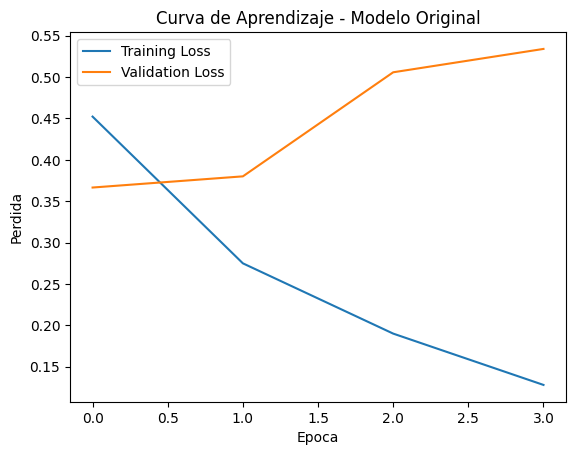

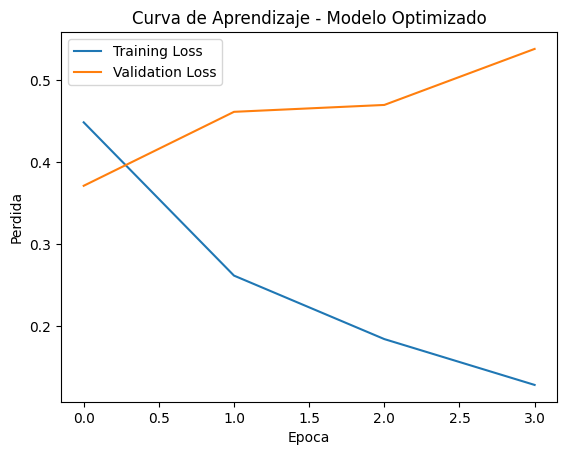

In [61]:
# Después del entrenamiento se puede revisar el historial
from matplotlib import pyplot as plt
import numpy as np

plt.title("Curva de Aprendizaje - Modelo Original")
plt.plot(np.arange(0,4), historia_og.history["loss"], label="Training Loss")
plt.plot(np.arange(0,4), historia_og.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoca")
plt.ylabel("Perdida")
plt.legend()
plt.show()

plt.title("Curva de Aprendizaje - Modelo Optimizado")
plt.plot(np.arange(0,4), historia_new.history["loss"], label="Training Loss")
plt.plot(np.arange(0,4), historia_new.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoca")
plt.ylabel("Perdida")
plt.legend()
plt.show()

**NOTA:** Si se entrenó el modelo en esta sesión y se desea guardar para otra aplicación o uso futuro, Ejecute la instrucción de la siguiente celda.  Si no lo entrenó en esta sesión, omita la ejecución. 

(En mi Mac con procesador M2, se tardo aprox 16 hrs)

**NOTA:** Si no se entrenó el modelo en esta sesión, pero lo tiene guardado, puede ejecutar la instrucciones de la siguiente celda.

In [17]:
from tensorflow.keras.models import load_model
modelo = load_model("Analisis_Sentimiento.keras")
modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

OK, ahora a evaluar la exactitud del modelo:

In [62]:
perdida, exactitud = modelo_original.evaluate(X_test, y_test,
                            batch_size = 64,
                            verbose = 2)
print("\n---- Modelo Orignial ----\n")
print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)

perdida, exactitud = modelo_nuevo.evaluate(X_test, y_test,
                            batch_size = 64,
                            verbose = 2)
print("\n---- Modelo Optimizado ----\n")
print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)

391/391 - 22s - 55ms/step - accuracy: 0.8215 - loss: 0.5341

---- Modelo Orignial ----

Pérdida de la Prueba: 0.5340715646743774
Exactitud de la Prueba (Test accuracy): 0.8215199708938599
391/391 - 37s - 95ms/step - accuracy: 0.8146 - loss: 0.5384

---- Modelo Optimizado ----

Pérdida de la Prueba: 0.5383949875831604
Exactitud de la Prueba (Test accuracy): 0.8145999908447266


Cerca del 80%, no está mal considerando que se limitó el ejercicio a las primeras 80 palabras de cada crítica.

Hay que pensar en lo que se hizo en este ejercicio!  Una red neuronal que puede leer críticas y deducir si al autor le gustó la película o no, basado en el texto.  Y el modelo toma en cuenta el contexto y la posición de cada palabra.

Lo mejor de todo es que armar el modelo solamente requirió de algunas líneas de código!  Es increíble lo que se puede hacer con Keras!!!

### Ver algo de las críticas

Del enlace provisto arriba, se obtuvo el siguiente código que permite ver el texto del primero de los comentarios.  No sería dificil verlos todos si se quisiera.

In [25]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
# Retrieve the training sequences.
(X_train, _), _ = tf.keras.datasets.imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)
# Retrieve the word index file mapping words to indices
word_index = tf.keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in X_train[0])

1641221/1641221 [==============================] - 0s 0us/step


In [26]:
decoded_sequence

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

## Confusion

In [74]:
y_pred1 = modelo_original.predict(X_test)
y_pred1 = [1 if p >=0.5 else 0 for p in y_pred1]

y_pred2= modelo_nuevo.predict(X_test)
y_pred2 = [1 if p >=0.5 else 0 for p in y_pred2]

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step


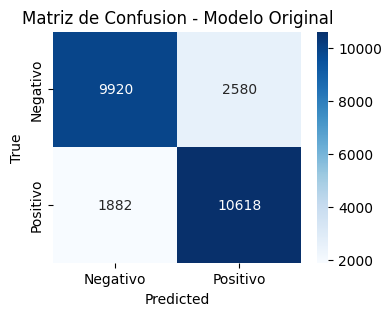

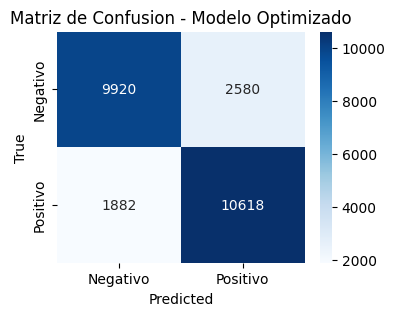

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm1 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(4,3))
plt.title("Matriz de Confusion - Modelo Original")
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negativo","Positivo"],
            yticklabels=["Negativo","Positivo"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm2 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(4,3))
plt.title("Matriz de Confusion - Modelo Optimizado")
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negativo","Positivo"],
            yticklabels=["Negativo","Positivo"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()